# Are you on PC or MAC? pc = 0, mac = 1

In [1]:
computer = 0

# IF YOU RUN THIS PAGE FOR THE FIRST TIME : 

# START HERE

# OTHERWISE, YOU CAN START BELOW TO AVOID FETCHING ALL THE DATA AGAIN

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

In [3]:
ROOTPATH = os.getcwd()
path = os.path.join(ROOTPATH, 'Data')

if not os.path.exists(path):
    os.makedirs(path)


# 1) This first part is only accessing in a list all the tickers in our fund, via a csv

In [4]:
# In the file IBB_holdings.csv, the tickers are sorted by descending weigths as of 5-Feb-18
# The file contains a lot of information about the fund IBB as of 5-Feb-18, which can be imported via row[i], i being the column you want
# For now we only import the first column, tickers.

if computer == 0:
    with open('IBB_holdings.csv', 'r') as csvfile:
        file = csv.reader(csvfile, delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c >= 11:
                list_tickers.append(row[0].split(',')[0])
            c+=1
else:
    with open('IBB_holdings.csv', 'r', encoding ='mac_roman') as csvfile:
        file = csv.reader(csvfile, delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c >= 11:
                list_tickers.append(row[0].split(',')[0])
            c+=1
            
list_tickers.sort()
list_tickers.pop()
list_tickers.remove("BLKFDS")
list_tickers.remove("USD")

# 2) We now want to download the data of all tickers as dataframes

In [5]:
# Setting up the variables

start_date = '2016-01-01'
end_date = '2018-01-01'


nb_tickers = len(list_tickers)
list_dataframes=[None]*(nb_tickers)

In [6]:
#On Yahoo
still_missing = nb_tickers
passages = 0

while still_missing > 0 and passages < 100:
    passages += 1
    print("harvest number " , passages)
    for i in range (nb_tickers ):
        if type(list_dataframes[i]) == type(None):   
            symbol = list_tickers[i]
            try:
                df = web.DataReader(symbol, 'yahoo' , start_date ,end_date)
                list_dataframes[i] = df
                still_missing -= 1
            except:
                print("Oops!  That was no valid ticker.  Try again... "+list_tickers[i])

harvest number  1
Oops!  That was no valid ticker.  Try again... ADMS
Oops!  That was no valid ticker.  Try again... ADRO
Oops!  That was no valid ticker.  Try again... AIMT
Oops!  That was no valid ticker.  Try again... ARNA
Oops!  That was no valid ticker.  Try again... CARA
Oops!  That was no valid ticker.  Try again... CLXT
Oops!  That was no valid ticker.  Try again... CNCE
Oops!  That was no valid ticker.  Try again... CRBP
Oops!  That was no valid ticker.  Try again... CRVS
Oops!  That was no valid ticker.  Try again... DBVT
Oops!  That was no valid ticker.  Try again... ECYT
Oops!  That was no valid ticker.  Try again... EPZM
Oops!  That was no valid ticker.  Try again... INO
Oops!  That was no valid ticker.  Try again... MCRB
Oops!  That was no valid ticker.  Try again... MGNX
Oops!  That was no valid ticker.  Try again... MRNS
Oops!  That was no valid ticker.  Try again... NSTG
Oops!  That was no valid ticker.  Try again... NTLA
Oops!  That was no valid ticker.  Try again... 

# 3) Finally, we can download in a new folder all this information for future use, to avoid downloading them from the web again

In [7]:
#Download of the dataframes as as many csv's (for now)

for i in range (nb_tickers ):  
    file_name = 'csv_' + list_tickers[i] + '_from_' + start_date + '_to_' + end_date + ".csv"
    string = path + '\\' + file_name
    list_dataframes[i].to_csv(string , sep=',')

# 4) This program is not (yet) collecting the two tickers that are not equities : BLKFDS and USD

# 5) We also need a benchmark

In [8]:
# Here the benchmark is NASDAQ Biotechnology index 
symbol='^NBI'
benchmark1 = web.DataReader(symbol, 'yahoo' , start_date ,end_date)

In [9]:
# Here the benchmark is iShares Nasdaq Biotechnology ETF 
symbol='IBB'
benchmark2 = web.DataReader(symbol, 'yahoo' , start_date ,end_date)

# 6) Now we need rate of returns

In [10]:
df_ror_1 = benchmark1['High'].pct_change()
df_ror_2 = benchmark2['High'].pct_change()

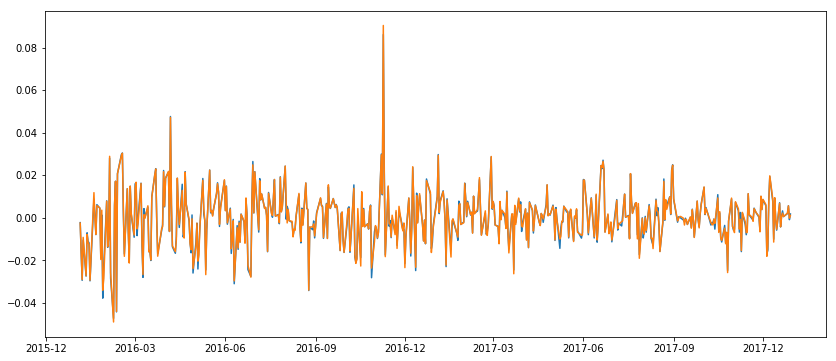

In [11]:
# Both benchmarks should have similar rate of returns, though they have different prices
plt.plot(df_ror_1)
plt.hold
plt.plot(df_ror_2)
plt.show;

In [12]:
def rateOfReturnWeekly(df,column):
    # Column has to be a column of the dataframe (ie 'Open','AdjClose')
    
    # Making sure dataframe is well sorted
    df_sorted = df.sort_index( ascending = True )
    

    # So far gives daily as shift = 1!
    shift = 1
    df_shifted = df_sorted.shift(shift)
    rate_of_returns = (df_sorted - df_shifted) / df_shifted
    rate_of_returns = rate_of_returns.drop(rate_of_returns.index[0])

    return rate_of_returns

# 7) Function to add noise to a dataframe (a new dataframe will be created)

In [13]:
def add_noise_2(df_origin, tick, mean = 0, std = 0.005):
    noise = []
    
    # Creating the noise
    for i in range(len(df_origin)):
        x = np.exp(np.random.normal(mean,std))
        noise.append(x)
        
    df_modified = df_origin.copy()
    df_modified['Adj Close'] = df_modified['Adj Close'].multiply(noise)
    
    file_name = 'csv_' + tick + '_B_' + str(mean) + '_' + str(std) + '_from_' + start_date + '_to_' + end_date + '.csv'
    string = path + file_name
    df_modified.to_csv(os.path.join(path,file_name), sep=',') 

# 8) Create all the new csv

In [14]:
allFiles = glob.glob(path + "/csv" + "*.csv")


i=0
if computer == 0:
    for file_ in allFiles:
        with open(file_, 'r') as csvfile:
            if list_tickers[i] != 'SNDX':
                df = pd.read_csv(csvfile, index_col=None, header=0)
                add_noise_2(df,list_tickers[i],0,0.01)
                #add_noise_2(df,list_tickers[i],0,0.008)
                #add_noise_2(df,list_tickers[i],0,0.0003)
                #add_noise_2(df,list_tickers[i],0,0.002)
                #add_noise_2(df,list_tickers[i],0,0.0006)
            i=i+1
    
if computer == 1:    
    for file_ in allFiles:
        with open(file_, 'r', encoding ='mac_roman') as csvfile:
            if list_tickers[i] != 'SNDX':
                df = pd.read_csv(csvfile, index_col=None, header=0)
                add_noise_2(df,list_tickers[i],0,0.01)
                #add_noise_2(df,list_tickers[i],0,0.008)
                #add_noise_2(df,list_tickers[i],0,0.0003)
                #add_noise_2(df,list_tickers[i],0,0.002)
                #add_noise_2(df,list_tickers[i],0,0.0006)
            i=i+1

# IF YOU RUN THIS PAGE FOR THE SECOND TIME : 

# START HERE

# Are you on PC or MAC? pc = 0, mac = 1

In [1]:
computer = 0

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

In [3]:
# Comprehensive way to set the path to Data directory

ROOTPATH = os.getcwd()

if not(ROOTPATH[-4:] == 'Data'):
    path = os.path.join(ROOTPATH, 'Data')
else:
    path = ROOTPATH

In [4]:
if computer == 0:
    with open('IBB_holdings.csv', 'r') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1

if computer == 1:
    with open('IBB_holdings.csv', 'r', encoding ='mac_roman') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1            

list_tickers.sort()
list_tickers.pop()
list_tickers.remove("BLKFDS")
list_tickers.remove("USD")
list_tickers.remove("SNDX")

In [5]:
nb_tickers = len(list_tickers)
list_dataframes=[None]*(2*nb_tickers+1) #SNDX
data = np.array([np.zeros(503)]*(2*nb_tickers)) 

allFiles = glob.glob(path + "/csv" + "*.csv")

i = 0
compt = 0
if computer == 0:
    for file_ in allFiles:
        with open(file_, 'r') as csvfile:
            df = pd.read_csv(csvfile, index_col=None, header=0)
            list_dataframes[i] = df
            arr = np.array(df['Adj Close'])
            if len(arr) == 503 and not df.isnull().values.any():    
                mini = np.min(arr)
                maxi = np.max(arr)
                arr = (arr - mini) / (maxi - mini)
                data[i] = arr
                i += 1
            else :
                compt += 1

if computer == 1:
    for file_ in allFiles:
        with open(file_, 'r', encoding ='mac_roman') as csvfile:
            df = pd.read_csv(csvfile, index_col=None, header=0)
            list_dataframes[i] = df
            arr = np.array(df['Adj Close'])
            if len(arr) == 503 and not df.isnull().values.any():    
                mini = np.min(arr)
                maxi = np.max(arr)
                arr = (arr - mini) / (maxi - mini)
                data[i] = arr
                i += 1
            else :
                compt += 1            
    
data = data[:-compt]  

np.random.shuffle(data)   

train_set = data[:-50]
test_set = data[-50:-25]
validation_set = data[-25:]

# 9) Set up the autoencoder

In [6]:
def next_batch(batch_size, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

In [50]:
# Training Parameters
learning_rate = 0.001
num_steps = 3000
batch_size = 10
lambd = 0

display_step = 100

# Network Parameters 

num_hidden_1 = 250 # 1st layer num features
#num_hidden_2 = 200 # 2nd layer num features (the latent dim)
num_input = 503 # 503 days considered


In [51]:
X = tf.placeholder("float", [None, num_input])
learning = tf.placeholder("float")
keep_prob = tf.placeholder(tf.float32) #gateway for dropout

In [52]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1],mean=0.0,
    stddev=1.0/np.sqrt(num_input))),
    #'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2],mean=0.0,
    #stddev=1.0/np.sqrt(num_hidden_1))),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_1, num_input],mean=0.0,
    stddev=1.0/np.sqrt(num_hidden_1))),
    #'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input],mean=0.0,
    #stddev=1.0/np.sqrt(num_hidden_1))),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_input])),
    #'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

In [53]:
# Building the encoder
def encoder(x,dropout):
    # x = tf.nn.dropout(x, dropout)
    # Encoder Hidden layer with relu activation #1
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with relu activation #2
    #layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
    #                               biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x, dropout):
    x = tf.nn.dropout(x, dropout)
    # Decoder Hidden layer with relu activation #1
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with relu activation #2
    #layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
    #                               biases['decoder_b2']))
    return layer_1

In [54]:
# Construct model
encoder_op = encoder(X, keep_prob)
decoder_op = decoder(encoder_op, keep_prob)

In [55]:
# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
#mse = tf.pow(y_true - y_pred, 2)
#loss = tf.reduce_sum(mse)

mse = tf.squared_difference(y_pred, y_true)

In [56]:
regularizer = tf.nn.l2_loss(weights['encoder_h1'])
#regularizer += tf.nn.l2_loss(weights['encoder_h2'])
regularizer += tf.nn.l2_loss(weights['decoder_h1'])
#regularizer += tf.nn.l2_loss(weights['decoder_h2'])
#loss = tf.reduce_mean(mse + lambd * regularizer)
loss = tf.reduce_sum(mse + lambd * regularizer)/(2 * num_input * 10)

#Replace learning_rate by learning to get an adaptative learning rate
optimizer = tf.train.AdamOptimizer(learning).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# 10) Train the autoencoder

In [57]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

costs = []

init_learn =  0.001
inter_learn = 0.0001
final_learn = 0.00001

learn = init_learn

dropout = .9

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = next_batch(batch_size,train_set,train_set)

    # Run optimization op (backprop) and cost op (to get loss value)
    if i==2000:
        learn = inter_learn
    elif i==4000:
        learn = final_learn
    
    _, l = sess.run([optimizer, loss], feed_dict={X: batch_x, learning : learn,  keep_prob : dropout})
    costs.append(l)
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))

Step 1: Minibatch Loss: 0.330119
Step 100: Minibatch Loss: 0.035154
Step 200: Minibatch Loss: 0.029393
Step 300: Minibatch Loss: 0.029980
Step 400: Minibatch Loss: 0.028102
Step 500: Minibatch Loss: 0.027977
Step 600: Minibatch Loss: 0.026280
Step 700: Minibatch Loss: 0.022370
Step 800: Minibatch Loss: 0.020109
Step 900: Minibatch Loss: 0.022481
Step 1000: Minibatch Loss: 0.029645
Step 1100: Minibatch Loss: 0.025167
Step 1200: Minibatch Loss: 0.030135
Step 1300: Minibatch Loss: 0.021323
Step 1400: Minibatch Loss: 0.028049
Step 1500: Minibatch Loss: 0.024616
Step 1600: Minibatch Loss: 0.024498
Step 1700: Minibatch Loss: 0.022884
Step 1800: Minibatch Loss: 0.025429
Step 1900: Minibatch Loss: 0.020259
Step 2000: Minibatch Loss: 0.021014
Step 2100: Minibatch Loss: 0.021348
Step 2200: Minibatch Loss: 0.020778
Step 2300: Minibatch Loss: 0.021302
Step 2400: Minibatch Loss: 0.021099
Step 2500: Minibatch Loss: 0.019120
Step 2600: Minibatch Loss: 0.020621
Step 2700: Minibatch Loss: 0.019396
Step

In [58]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 10

for i in range(n):
    # MNIST test set
    batch_x, _ = next_batch(10,test_set,test_set)
    # Encode and decode the digit image)
    l , p = sess.run([loss,y_pred] , feed_dict={X: batch_x,  keep_prob : 1})
    print('Minibatch Loss: ', l)    

Minibatch Loss:  0.0216568
Minibatch Loss:  0.019139
Minibatch Loss:  0.021774
Minibatch Loss:  0.0222199
Minibatch Loss:  0.0202744
Minibatch Loss:  0.0240208
Minibatch Loss:  0.021236
Minibatch Loss:  0.0180116
Minibatch Loss:  0.0221274
Minibatch Loss:  0.0212779


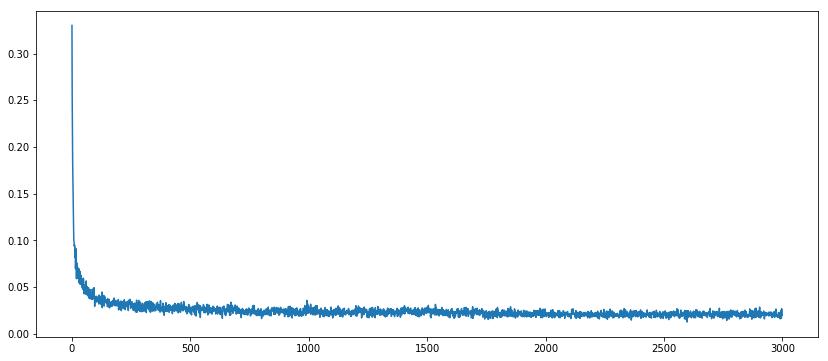

In [59]:
plt.plot(costs)
plt.show()

In [60]:
for i in p:
    print(i)

[ 0.          0.31126857  0.24287748  0.23300003  0.26902205  0.2300691
  0.20693363  0.2103312   0.19152646  0.          0.1790309   0.16648878
  0.          0.17353576  0.15986741  0.21191351  0.16191164  0.          0.1477344
  0.          0.12203937  0.13997573  0.07944065  0.          0.08110513
  0.03353135  0.          0.02398768  0.0263488   0.          0.1374467
  0.06988418  0.08637542  0.098407    0.          0.09509617  0.07516474
  0.04446715  0.05172449  0.03444946  0.09831236  0.14829308  0.13211709
  0.12531139  0.11223799  0.12672672  0.          0.13120985  0.
  0.15372674  0.15884507  0.14104533  0.12660789  0.17137843  0.19208369
  0.09726703  0.          0.          0.19006097  0.          0.
  0.24211384  0.24942386  0.          0.          0.31707287  0.29080504
  0.          0.30725166  0.28524953  0.31378329  0.32467309  0.
  0.34035254  0.          0.35231185  0.41196984  0.35417002  0.34917527
  0.34835199  0.36224717  0.36100113  0.37031594  0.33708209  0.33

In [61]:
print(1 - np.count_nonzero(p)/np.size(p),"%  \'0\' values")

0.18409542743538765 %  '0' values


In [62]:
for i in batch_x:
    print(i)

[ 0.35822619  0.36083418  0.29967057  0.26926399  0.23863452  0.20036156
  0.25337659  0.17382174  0.2322694   0.1744888   0.12621056  0.14396047
  0.14388849  0.15628043  0.14971043  0.14098181  0.08653771  0.06500935
  0.09544624  0.11682261  0.05870997  0.08771345  0.08852583  0.04470567
  0.          0.01446192  0.01319106  0.0075572   0.01398786  0.0296969
  0.05029183  0.04766491  0.06294147  0.07245909  0.13636738  0.14994103
  0.13194118  0.13356054  0.1030394   0.13937367  0.16028474  0.15069305
  0.15307821  0.1842486   0.15370361  0.14467418  0.1265315   0.16796657
  0.15280725  0.11167785  0.07140388  0.07493686  0.08363541  0.10658036
  0.14151682  0.11140362  0.10161633  0.08721553  0.08633998  0.09549333
  0.13033448  0.11925454  0.1877865   0.17206221  0.27789614  0.27271989
  0.27475024  0.27266387  0.27924026  0.31713352  0.30859804  0.30882994
  0.3858603   0.40826194  0.43000304  0.45509653  0.45618918  0.43095184
  0.44407845  0.38916833  0.42246531  0.38002068  0.

[ 0.88037817  0.81130275  0.73676404  0.67901045  0.68432147  0.60181954
  0.46198503  0.35266149  0.3559182   0.57214832  0.48036551  0.52248738
  0.46155607  0.39872496  0.36748427  0.3875636   0.35958707  0.37279836
  0.4141107   0.37308691  0.36001895  0.26265542  0.34299465  0.38803124
  0.2642147   0.27746609  0.27820183  0.29831007  0.29028376  0.25973763
  0.31564385  0.31935606  0.3029967   0.33874715  0.29555642  0.28668545
  0.30057088  0.31397117  0.32316461  0.30992491  0.29135276  0.29366589
  0.29473011  0.3959994   0.49374916  0.5118561   0.4663377   0.46724158
  0.45583623  0.4400535   0.43071817  0.38926873  0.35254769  0.37787746
  0.33623594  0.37062118  0.34556079  0.3127729   0.41554007  0.45592807
  0.41792698  0.45835909  0.49757053  0.48136347  0.45310263  0.45301609
  0.42442164  0.38327884  0.41211629  0.41779368  0.44588646  0.42691678
  0.49448562  0.54127428  0.47812543  0.47421388  0.50091967  0.57384894
  0.52362328  0.53980711  0.51083263  0.51574848  0

In [63]:
for i in p:
    print(i)

[ 0.          0.31126857  0.24287748  0.23300003  0.26902205  0.2300691
  0.20693363  0.2103312   0.19152646  0.          0.1790309   0.16648878
  0.          0.17353576  0.15986741  0.21191351  0.16191164  0.          0.1477344
  0.          0.12203937  0.13997573  0.07944065  0.          0.08110513
  0.03353135  0.          0.02398768  0.0263488   0.          0.1374467
  0.06988418  0.08637542  0.098407    0.          0.09509617  0.07516474
  0.04446715  0.05172449  0.03444946  0.09831236  0.14829308  0.13211709
  0.12531139  0.11223799  0.12672672  0.          0.13120985  0.
  0.15372674  0.15884507  0.14104533  0.12660789  0.17137843  0.19208369
  0.09726703  0.          0.          0.19006097  0.          0.
  0.24211384  0.24942386  0.          0.          0.31707287  0.29080504
  0.          0.30725166  0.28524953  0.31378329  0.32467309  0.
  0.34035254  0.          0.35231185  0.41196984  0.35417002  0.34917527
  0.34835199  0.36224717  0.36100113  0.37031594  0.33708209  0.33

[ 0.          0.70124638  0.6979568   0.56242472  0.54759407  0.53174758
  0.53446418  0.5044294   0.54012012  0.          0.50486231  0.54419357
  0.          0.55199778  0.56710291  0.56607056  0.48845449  0.
  0.48943603  0.          0.50407797  0.49880704  0.50212604  0.          0.3728863
  0.38397986  0.          0.41602117  0.42451018  0.          0.49270806
  0.44900188  0.46023896  0.44117358  0.          0.45763856  0.45083547
  0.45364863  0.44370016  0.42615551  0.45126128  0.43290079  0.45429221
  0.42644024  0.37356192  0.35834759  0.          0.36546165  0.          0.3212457
  0.25928736  0.25364152  0.25508034  0.25376838  0.26929763  0.12261891
  0.          0.          0.25518826  0.          0.          0.29100987
  0.29617032  0.          0.          0.2714113   0.32151592  0.
  0.28005159  0.31879818  0.31584293  0.33155394  0.          0.3031953   0.
  0.35402489  0.40274882  0.33119619  0.35142899  0.33361089  0.33938721
  0.23110628  0.33189324  0.32703099  0.2

In [64]:
diff = abs(p - batch_x)

In [65]:
for i in diff:
    print(i)

[  3.58226190e-01   4.95656169e-02   5.67930823e-02   3.62639611e-02
   3.03875246e-02   2.97075367e-02   4.64429607e-02   3.65094620e-02
   4.07429425e-02   1.74488798e-01   5.28203373e-02   2.25283114e-02
   1.43888486e-01   1.72553305e-02   1.01569713e-02   7.09316976e-02
   7.53739272e-02   6.50093527e-02   5.22881655e-02   1.16822606e-01
   6.33293978e-02   5.22622804e-02   9.08518148e-03   4.47056652e-02
   8.11051279e-02   1.90694346e-02   1.31910595e-02   1.64304824e-02
   1.23609361e-02   2.96969029e-02   8.71548753e-02   2.22192690e-02
   2.34339417e-02   2.59479151e-02   1.36367382e-01   5.48448630e-02
   5.67764490e-02   8.90933848e-02   5.13149098e-02   1.04924208e-01
   6.19723799e-02   2.39997563e-03   2.09611165e-02   5.89372073e-02
   4.14656163e-02   1.79474600e-02   1.26531496e-01   3.67567221e-02
   1.52807246e-01   4.20488962e-02   8.74411906e-02   6.61084724e-02
   4.29724833e-02   6.47980689e-02   5.05668635e-02   1.41365844e-02
   1.01616328e-01   8.72155289e-02

[  9.24468843e-01   1.35400295e-02   2.00520004e-02   2.79877979e-02
   5.08817164e-03   6.61035824e-02   3.62040544e-02   1.29322065e-02
   1.22088319e-01   6.75058930e-01   5.08794042e-02   1.35695140e-02
   5.58615264e-01   1.01180552e-01   5.58450033e-05   8.09587427e-04
   5.45955117e-03   4.35090480e-01   2.74989785e-02   5.47600315e-01
   5.05249452e-02   3.30507051e-02   8.80084773e-02   3.82376082e-01
   1.96903487e-02   3.16952240e-02   2.00629426e-01   7.33560233e-02
   1.21045062e-02   2.58064516e-01   6.00588647e-02   2.54541730e-02
   1.80329409e-02   4.33061617e-02   2.21872541e-01   1.09863421e-01
   5.11236940e-02   2.01861325e-02   7.06115176e-03   5.50982419e-02
   1.39323834e-01   6.60326620e-02   9.98706516e-02   6.33953889e-02
   1.23097512e-02   3.00537450e-02   3.14712746e-01   1.92820199e-02
   4.24862392e-01   1.95368920e-02   5.44198070e-03   1.79491612e-02
   5.51258362e-02   4.58093220e-02   4.94948833e-02   3.80948445e-04
   3.57985838e-01   3.71361133e-01

In [66]:
print('average error in our case = ',np.mean(diff))

average error in our case =  0.109587541026


In [67]:
random = np.random.uniform(0,1,(10,503))

In [68]:
diff_random = abs(batch_x - random)
print('average error in a random case = ',np.mean(diff_random))

average error in a random case =  0.307291802748
